<a href="https://colab.research.google.com/github/yeshitt/Sentiment_Analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re
from nltk.stem import  WordNetLemmatizer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from scipy.sparse import hstack
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud


In [ ]:
df = pd.read_csv('Dataset.csv')

In [ ]:
df.head()


,product_name,product_price,Rate,Review,Summary,Sentiment
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,super!,great cooler excellent air flow and for this p...,positive
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,awesome,best budget 2 fit cooler nice cooling,positive
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,the quality is good but the power of air is de...,positive
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1,useless product,very bad product its a only a fan,negative
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,ok ok product,neutral


In [ ]:
df.shape

(35029, 6)

In [ ]:
df.isnull().sum()

product_name     0
product_price    0
Rate             0
Review           0
Summary          2
Sentiment        1
dtype: int64

In [ ]:

# Counting the number of null values in the 'Review' column
null_values = df['Review'].isnull().sum()
print("Number of null values:", null_values)

Number of null values: 0


In [ ]:
# Identifying different representations of null values in the 'Review' column
different_null_values = df['Review'].apply(lambda x: x if pd.isnull(x) else None).unique()
print("Different representations of null values:", different_null_values)

Different representations of null values: [None]


In [ ]:
#Converting the 'Rate' column to numeric, coercing invalid values to NaN
df['Rate'] = pd.to_numeric(df['Rate'], errors='coerce')

# Filling null values in the 'Review' column based on the corresponding 'Rate' values
df['Review'] = np.where((df['Review'].isnull()) & (df['Rate'] < 3), 'Not satisfied.', df['Review'])
df['Review'] = np.where((df['Review'].isnull()) & (df['Rate'] == 3), 'Average quality', df['Review'])
df['Review'] = np.where((df['Review'].isnull()) & (df['Rate'] > 3), 'Great product!', df['Review'])

# Creating a new column 'Reviews' and assigning the values from the 'Review' column
df['Reviews'] = df['Review']

# Counting the number of remaining null values in the 'Reviews' column
null_values = df['Reviews'].isnull().sum()
print("Number of remaining null values:", null_values)




Number of remaining null values: 0


In [ ]:
df.head()


,product_name,product_price,Rate,Review,Summary,Sentiment,Reviews
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5.0,super!,great cooler excellent air flow and for this p...,positive,super!
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5.0,awesome,best budget 2 fit cooler nice cooling,positive,awesome
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3.0,fair,the quality is good but the power of air is de...,positive,fair
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1.0,useless product,very bad product its a only a fan,negative,useless product
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3.0,fair,ok ok product,neutral,fair


In [ ]:

columns= ['Review']
df = df.drop(columns=columns)

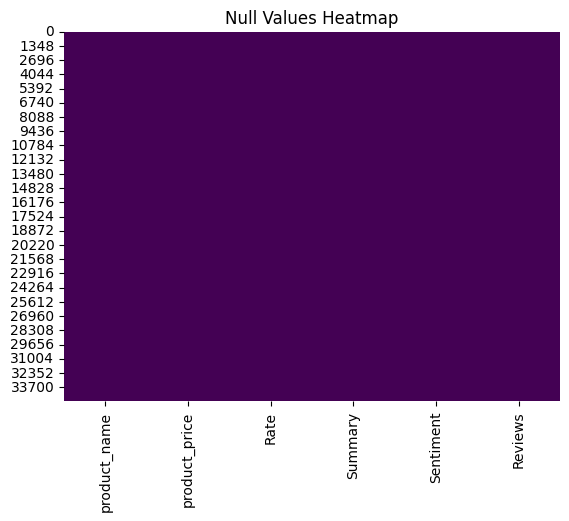

In [ ]:
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Null Values Heatmap')
plt.show()

In [ ]:
df.isnull().sum()

product_name     0
product_price    0
Rate             1
Summary          2
Sentiment        1
Reviews          0
dtype: int64

In [ ]:
df =df.dropna()

In [ ]:
columns= ['product_name','product_price']
df = df.drop(columns=columns)

In [ ]:
new_column_order = ['Rate','Reviews','Summary','Sentiment' ]
df = df.reindex(columns=new_column_order)

In [ ]:
# Converting the 'Summary' and 'Reviews' column to lowercase
df['Summary'] = df['Summary'].str.lower()
df['Reviews'] = df['Reviews'].str.lower()

In [ ]:
# Removing punctuation from the 'Summary' and 'reviews' column
df['Summary'] = df['Summary'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df['Reviews'] = df['Reviews'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [ ]:
# Tokenizing the text using the 'punkt' tokenizer from NLTK
nltk.download('punkt')
df['Summary'] = df['Summary'].apply(word_tokenize)
df['Reviews'] = df['Reviews'].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Downloading the stopwords corpus from NLTK
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
# Removing stopwords from the 'Summary' and 'Reviews' columns
df['Summary'] = df['Summary'].apply(lambda x: [word for word in x if word not in stopwords])
df['Reviews'] = df['Reviews'].apply(lambda x: [word for word in x if word not in stopwords])
# Joining the list of words back into a string for 'Summary' and 'Reviews' columns
df['Summary'] = df['Summary'].apply(lambda x: ' '.join(x))
df['Reviews'] = df['Reviews'].apply(lambda x: ' '.join(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Downloading the WordNet corpus from NLTK
nltk.download('wordnet')
# Initializing the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()
# Lemmatizing the words in the 'Summary' and 'Reviews' columns
df['Summary'] = df['Summary'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
df['Reviews'] = df['Reviews'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))



[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
import pandas as pd
sentiment_mapping = {"positive": 2, "negative": 0,"neutral":1}
df['Sentiment'] = df['Sentiment'].map(sentiment_mapping)

In [ ]:
df.head()

,Rate,Reviews,Summary,Sentiment
0,5.0,super,great cooler excellent air flow price amazing ...,2
1,5.0,awesome,best budget 2 fit cooler nice cooling,2
2,3.0,fair,quality good power air decent,2
3,1.0,useless product,bad product fan,0
4,3.0,fair,ok ok product,1


In [ ]:
#counting number of positive,negative and neutral sentiments
positive_count = df['Sentiment'].value_counts()[2]
negative_count = df['Sentiment'].value_counts()[0]
neutral_count = df['Sentiment'].value_counts()[1]
print("Number of positive sentiments:", positive_count)
print("Number of negative sentiments:", negative_count)
print("Number of neutral sentiments:", neutral_count)



Number of positive sentiments: 28073
Number of negative sentiments: 5352
Number of neutral sentiments: 1600


In [ ]:

pip install wordcloud

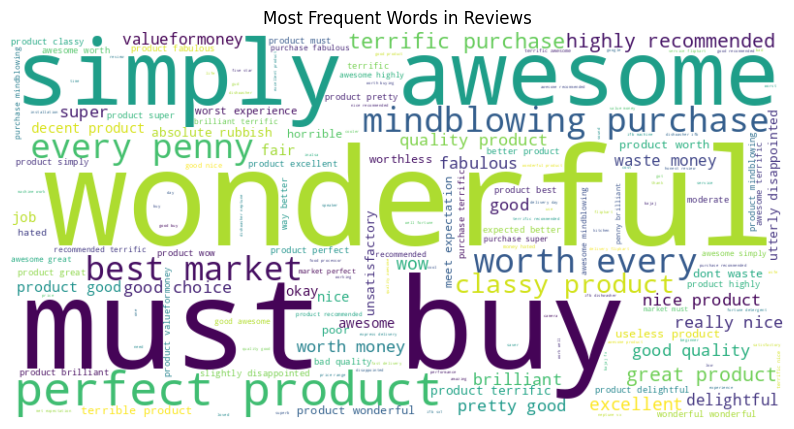

In [ ]:
# Concatenate the reviews into a single string
all_reviews = ' '.join(df['Reviews'])
# Generate a word cloud from the reviews
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)
# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Reviews')
plt.show()


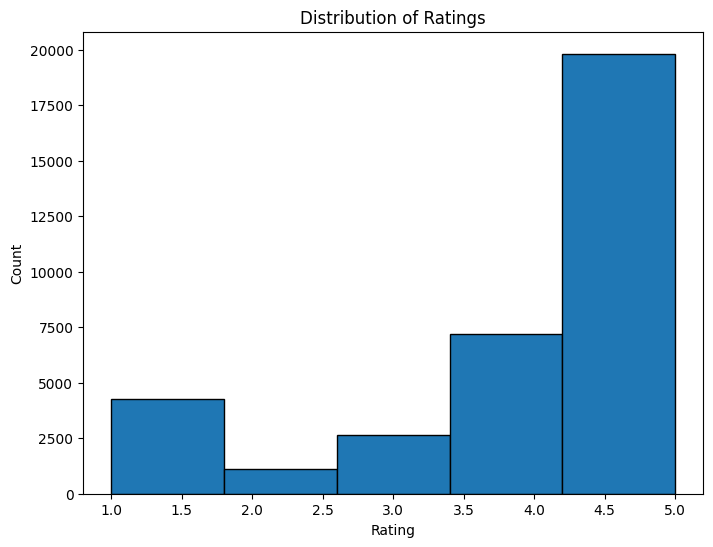

In [ ]:
#ploting bar graph for distribution of ratings
plt.figure(figsize=(8, 6))
plt.hist(df['Rate'], bins=5, edgecolor='k')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()



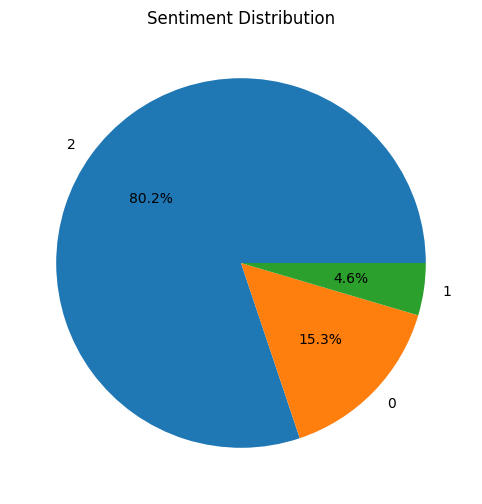

In [ ]:
# Count the number of occurrences for each sentiment category
sentiment_counts = df['Sentiment'].value_counts()
# Create a pie chart to visualize the sentiment distribution
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.show()

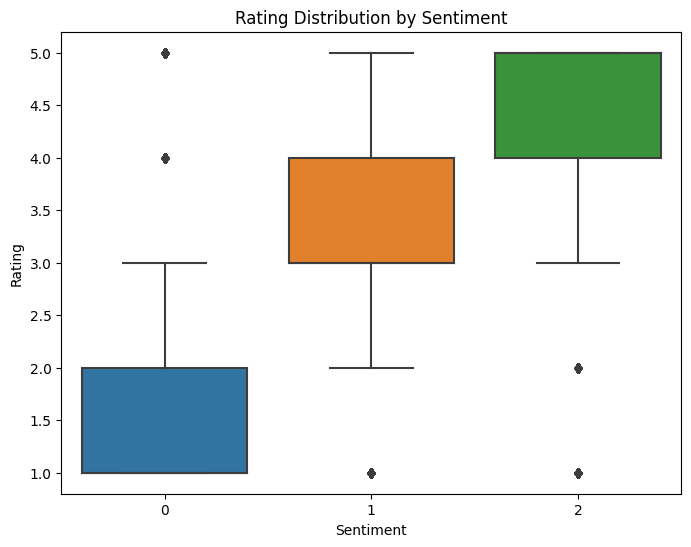

In [ ]:
# Create a box plot to compare ratings across different sentiment categories
plt.figure(figsize=(8, 6))
sns.boxplot(x='Sentiment', y='Rate', data=df)
plt.xlabel('Sentiment')
plt.ylabel('Rating')
plt.title('Rating Distribution by Sentiment')
plt.show()

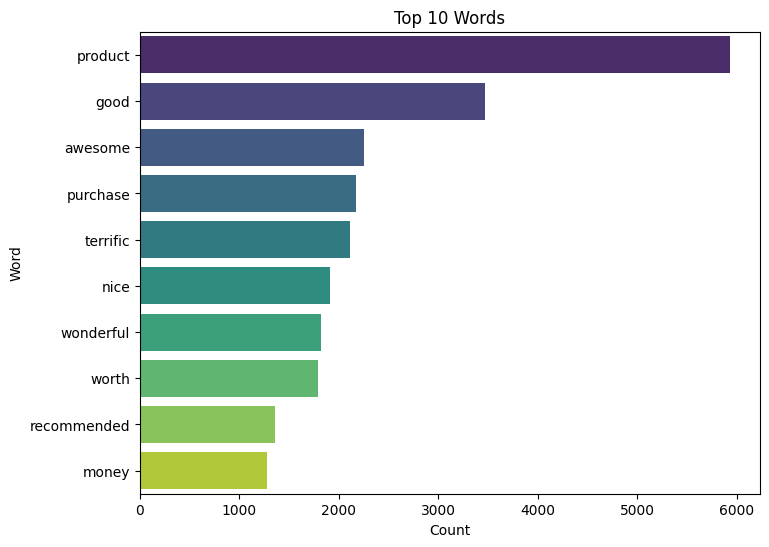

In [ ]:
# Get the top N most frequent words
top_n = 10
top_words = df['Reviews'].str.split(expand=True).stack().value_counts().head(top_n)
# Create a bar chart to visualize the top N words
plt.figure(figsize=(8, 6))
sns.barplot(x=top_words.values, y=top_words.index, palette='viridis')
plt.xlabel('Count')
plt.ylabel('Word')
plt.title(f'Top {top_n} Words')
plt.show()


In [ ]:

#Train_test_split model
X = df[['Rate','Reviews','Summary']]
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initializing a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
# Creating a pipeline for text feature extraction using TF-IDF
text_pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
])
# Creating a numerical transformer to reshape the numerical features
numerical_transformer = FunctionTransformer(lambda x: x.reshape(-1, 1), validate=False)
# Creating a feature union to combine the text and numerical features
feature_union = FeatureUnion([
    ('text', text_pipeline),
    ('numerical', numerical_transformer)
])
# Creating a pipeline to combine the features
pipeline = Pipeline([
    ('features', feature_union)
])
# Transforming the text features in the training set using TF-IDF
X_train_text_transformed = text_pipeline.fit_transform(X_train['Reviews'])
# Reshaping the numerical features in the training set
X_train_numerical = X_train['Rate'].values.reshape(-1, 1)
# Combining the text and numerical features in the training set
X_train_final = hstack([X_train_text_transformed, X_train_numerical])
# Transforming the text features in the test set using TF-IDF
X_test_text_transformed = text_pipeline.transform(X_test['Reviews'])
# Reshaping the numerical features in the test set
X_test_numerical = X_test['Rate'].values.reshape(-1, 1)
# Combining the text and numerical features in the test set
X_test_final = hstack([X_test_text_transformed, X_test_numerical])



In [ ]:

# Apply SMOTE to handle the imbalanced classes
oversampler = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_final, y_train)
# Apply RandomUnderSampler to further balance the classes
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)
# Count the number of samples in each sentiment class
positive_count = sum(y_train_resampled == 2)
negative_count = sum(y_train_resampled == 0)
neutral_count = sum(y_train_resampled == 1)
# Print the counts
print("Number of positive samples:", positive_count)
print("Number of negative samples:", negative_count)
print("Number of neutral samples:", neutral_count)

Number of positive samples: 22481
Number of negative samples: 22481
Number of neutral samples: 22481


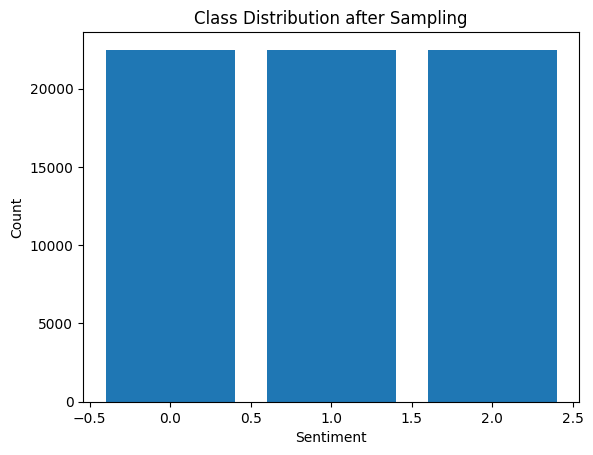

In [ ]:
# Count the occurrences of each class in the resampled training data
class_counts = y_train_resampled.value_counts()
# Plot the class distribution
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Class Distribution after Sampling')
plt.show()


In [ ]:
df.head()

,Rate,Reviews,Summary,Sentiment
0,5.0,super,great cooler excellent air flow price amazing ...,2
1,5.0,awesome,best budget 2 fit cooler nice cooling,2
2,3.0,fair,quality good power air decent,2
3,1.0,useless product,bad product fan,0
4,3.0,fair,ok ok product,1


In [ ]:
print("X_train_resampled shape:", X_train_resampled.shape)
print("X_train_resampled data type:", type(X_train_resampled))
print("X_test_final shape:", X_test_final.shape)
print("X_test_final data type:", type(X_test_final))


X_train_resampled shape: (67443, 404)
X_train_resampled data type: <class 'scipy.sparse._csr.csr_matrix'>
X_test_final shape: (7005, 404)
X_test_final data type: <class 'scipy.sparse._coo.coo_matrix'>


In [ ]:

# Initializing an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)
# Fitting the XGBoost classifier on the resampled training data
xgb_classifier.fit(X_train_resampled, y_train_resampled)
# Predicting the sentiment labels for the test data
y_pred = xgb_classifier.predict(X_test_final)
# Printing the classification report to evaluate the model's performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1078
           1       0.15      0.36      0.21       335
           2       0.96      0.87      0.92      5592

    accuracy                           0.84      7005
   macro avg       0.64      0.69      0.65      7005
weighted avg       0.90      0.84      0.87      7005



In [ ]:
# Initializing a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
# Fitting the Random Forest classifier on the resampled training data
rf_classifier.fit(X_train_resampled, y_train_resampled)
# Predicting the sentiment labels for the test data
y_pred = rf_classifier.predict(X_test_final)
# Printing the classification report to evaluate the model's performance
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1078
           1       0.15      0.37      0.21       335
           2       0.96      0.87      0.92      5592

    accuracy                           0.84      7005
   macro avg       0.64      0.70      0.65      7005
weighted avg       0.90      0.84      0.87      7005



In [ ]:
# Initializing a Logistic Regression model
model = LogisticRegression()
# Fitting the Logistic Regression model on the resampled training data
model.fit(X_train_resampled, y_train_resampled)
# Predicting the sentiment labels for the test data
y_pred = model.predict(X_test_final)
# Printing the classification report to evaluate the model's performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      1078
           1       0.16      0.40      0.23       335
           2       0.96      0.88      0.92      5592

    accuracy                           0.85      7005
   macro avg       0.65      0.70      0.66      7005
weighted avg       0.90      0.85      0.87      7005



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
model.predict(X_test_final)

array([0, 2, 2, ..., 2, 1, 2])

In [ ]:
y_test

17079    0
16272    2
27985    2
18129    2
6350     2
        ..
12510    2
18240    2
2585     2
19187    2
10030    2
Name: Sentiment, Length: 7005, dtype: int64